In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from collections import Counter
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [3]:
pd.plotting.register_matplotlib_converters()

In [4]:
cwd = os.getcwd()
PROJECT_PATH = cwd.split("quince_assignment")[0] + 'quince_assignment'
sys.path.insert(0, PROJECT_PATH)

In [5]:
from src.visualization.cm_pretty_print import *

In [6]:
event_data = pd.read_csv(f"{PROJECT_PATH}/src/data/event_202012182112.csv.gz", compression="gzip")

In [7]:
event_data['event_time'] = pd.to_datetime(event_data['event_time'], format="%Y-%m-%d %H:%M:%S")

In [8]:
event_data['lb_user_id'].nunique()

588808

In [9]:
event_type_order = {
    'collection_view': '1',
    'product_view': '2',
    'add_to_cart': '3',
    'checkout_page_view_contact_information': '4a',
    'checkout_page_view_shipping_method': '4b',
    'checkout_page_view_payment_method': '4c',
    'checkout_page_view_processing': '4d',
    'checkout_page_view_stock_problems': '4e',
    'checkout_page_view_review': '4f',
    'checkout_page_view_forward': '4g',
    'order_complete': '5',
    'email_subscription_view': '6',
    np.NaN: '7'
}

In [10]:
event_type_inverse_order = {v: k for k, v in event_type_order.items()}

In [11]:
event_data = event_data.assign(event_num = event_data['event_type'])
event_data.replace({'event_num': event_type_order}, inplace=True)

## Create session level data

In [12]:
aggregations = {
    'event_time': ['max', 'min'],
    'event_num': [lambda x: '->'.join(x), 'count'],
    'product_category': lambda x: pd.Series.mode(x.dropna())[0] if len(pd.Series.mode(x.dropna())) > 0 else "none"
}
session_data = event_data.groupby([
    'session_id', 'lb_user_id', 'device', 'device_category', 'user_gender',
    'user_state'
]).agg(aggregations)
session_data.reset_index(inplace=True)
session_data.columns = [
    'session_id', 'lb_user_id', 'device', 'device_category', 'user_gender',
    'user_state', 'session_end_time', 'session_start_time', 'event_sequence',
    'no_of_events', 'product_category'
]

In [13]:
session_data = session_data.assign(session_duration_sec=(
    session_data['session_end_time'] -
    session_data['session_start_time']).dt.total_seconds())
session_data = session_data.assign(made_purchase=np.where(
    session_data['event_sequence'].str.contains("5"), 1, 0))
session_data = session_data.assign(
    visit_count=session_data.groupby('lb_user_id')['session_end_time'].rank(
        method='min'))
session_data = session_data.assign(bought_on_first_visit=np.where(
    (session_data['visit_count'] == 1)
    & (session_data['made_purchase'] == 1), 1, 0))

In [14]:
session_data = session_data.assign(no_of_purchases = session_data['event_sequence'].str.count("5"))

In [15]:
cond = (session_data['event_sequence'].str.contains('1')) | (session_data['event_sequence'].str.contains('2'))
session_data = session_data.assign(visited_prod_coll = np.where(cond, 1, 0))

In [16]:
session_data.head()

,session_id,lb_user_id,device,device_category,user_gender,user_state,session_end_time,session_start_time,event_sequence,no_of_events,product_category,session_duration_sec,made_purchase,visit_count,bought_on_first_visit,no_of_purchases,visited_prod_coll
0,_00022uznd,_oqprf6nav,desktop,Windows,Male,New York,2020-11-23 02:59:50,2020-11-23 02:59:03,1->1->2,3,Apparel,47.0,0,10.0,0,0,1
1,_0004g0yuv,_m8i0dtjj6,mobile,iPhone,Female,Maryland,2020-11-11 12:25:05,2020-11-11 12:24:56,2->6,2,Apparel,9.0,0,1.0,0,0,1
2,_000dfqvrj,_kn3otbq1a,mobile,iPhone,Female,Massachusetts,2020-10-04 23:32:01,2020-10-04 23:31:39,2->1,2,Home,22.0,0,1.0,0,0,1
3,_000frx5lw,_u6ia8ze08,mobile,iPhone,Female,Virginia,2020-09-20 14:35:27,2020-09-20 13:07:20,1->6->1->2->3->2->3->2,8,Accessories,5287.0,0,1.0,0,0,1
4,_000q43w78,_an7s8iurw,mobile,iPhone,Female,New York,2020-09-29 13:22:18,2020-09-29 13:22:13,2->6,2,Apparel,5.0,0,1.0,0,0,1


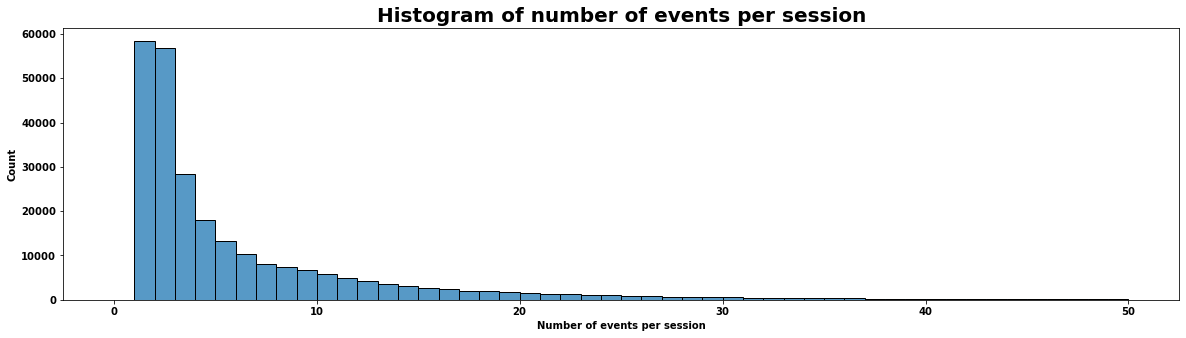

In [17]:
plt.figure(figsize=(20,5))
ax = sns.histplot(data=session_data, x='no_of_events', bins=50, binrange=(0, 50))
ax.set(xlabel="Number of events per session")
plt.title("Histogram of number of events per session", size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/sess_data_explr_plot1.jpg")

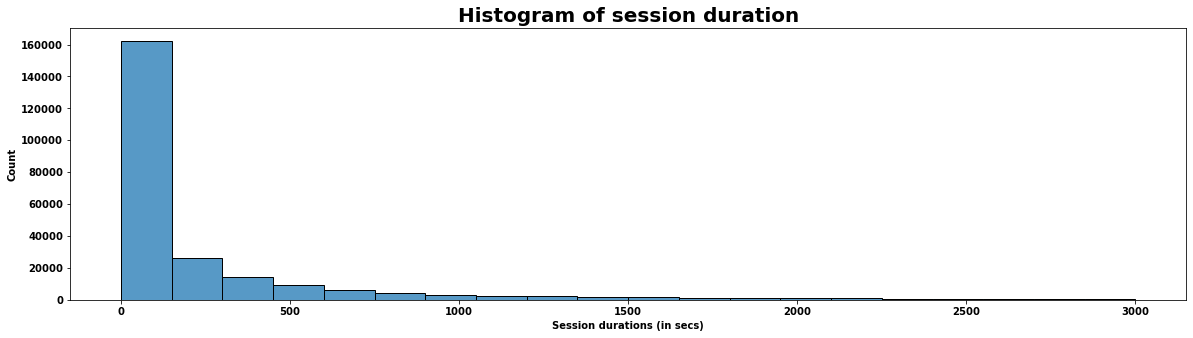

In [18]:
plt.figure(figsize=(20,5))
ax = sns.histplot(data=session_data, x='session_duration_sec', bins=20, binrange=(0, 3000))
ax.set(xlabel="Session durations (in secs)")
plt.title("Histogram of session duration", size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/sess_data_explr_plot2.jpg")

## User level data

In [19]:
user_level_aggregation = {
    'session_duration_sec': 'mean',
    'no_of_events': 'mean',
    'session_duration_sec': 'mean',
    'visit_count': 'count',
    'made_purchase': 'sum',
    'bought_on_first_visit': 'sum',
    'device': lambda x: pd.Series.mode(x)[0],
    'device_category': lambda x: pd.Series.mode(x)[0],
    'user_state': lambda x: pd.Series.mode(x)[0],
    'product_category': lambda x: pd.Series.mode(x[x!="none"])[0] if len(pd.Series.mode(x[x!="none"])) > 0 else "none"
}

user_data = session_data.groupby(['lb_user_id',
                                  'user_gender']).agg(user_level_aggregation)

In [20]:
user_data_v = user_data.copy()

In [21]:
user_data.reset_index(inplace=True)
# user_data = user_data.iloc[:, -10:]
user_data.columns = [
    'lb_user_id', 'user_gender', 'avg_session_duration', 'avg_no_of_events',
    'times_visited', 'times_purchased', 'bought_on_first_visit',
    'most_used_device', 'most_used_device_category', 'state_most_used_from',
    'products_category'
]

In [22]:
user_data = user_data.assign(repeat_customer=np.where(user_data['times_purchased']>1, 1, 0))

In [23]:
def create_user_funnel(session_data, description=""):
    print(f"User funnel for {description}")
    print("-"*50)
    
    unique_events = []

    event_sequences = session_data['event_sequence'].values
    
    for event_sequence in event_sequences:
        event_sequence = event_sequence.split('->')
        event_set_list = list(set(event_sequence))
        unique_events.extend(event_set_list)
        
    user_funnel = Counter(unique_events)
    den = session_data.shape[0]

    print(f"Total no of sessions is {den} - 100%")
    print("="*50)
    
    for key in event_type_order.values():
        desc = event_type_inverse_order[key]
        print(f"Count for {desc} is {user_funnel[key]} - {np.round(user_funnel[key]/den*100,2)}%")
        print("="*50)

In [24]:
create_user_funnel(session_data, "User funnel for overall data")

User funnel for User funnel for overall data
--------------------------------------------------
Total no of sessions is 256827 - 100%
Count for collection_view is 158158 - 61.58%
Count for product_view is 211270 - 82.26%
Count for add_to_cart is 58322 - 22.71%
Count for checkout_page_view_contact_information is 39648 - 15.44%
Count for checkout_page_view_shipping_method is 23263 - 9.06%
Count for checkout_page_view_payment_method is 23302 - 9.07%
Count for checkout_page_view_processing is 21357 - 8.32%
Count for checkout_page_view_stock_problems is 2074 - 0.81%
Count for checkout_page_view_review is 148 - 0.06%
Count for checkout_page_view_forward is 558 - 0.22%
Count for order_complete is 29546 - 11.5%
Count for email_subscription_view is 126563 - 49.28%
Count for nan is 10254 - 3.99%


# Metrics

## Order complete rate

In [25]:
order_complete_rate = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W-Tue')).agg({
        'no_of_purchases': lambda x: (x>0).sum(),
        'session_id': 'count'
    }).reset_index()
order_complete_rate.columns = ['week_ending_in', 'purchase_sessions', 'all_sessions']
order_complete_rate = order_complete_rate.assign(
    order_complete_rate=order_complete_rate['purchase_sessions'] /
    order_complete_rate['all_sessions'])

## Completed orders

In [26]:
completed_orders = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W-Tue')).agg({
        'no_of_purchases': 'sum'
    }).reset_index()
completed_orders.columns = ['week_ending_in', 'total_no_of_orders']

## Bounce Rate

In [27]:
bounce_rate = session_data.set_index('session_start_time').groupby(pd.Grouper(freq='W-Tue')).agg(
    {
        'visited_prod_coll': 'sum',
        'session_id': 'count'
    }).reset_index()
bounce_rate.columns = ['week_ending_in', 'unbounce_sessions', 'all_sessions']
bounce_rate = bounce_rate.assign(bounce_rate=1-(bounce_rate['unbounce_sessions']/bounce_rate['all_sessions']))

## Cart Abandonment Rate

In [28]:
cart_abd_rate = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W-Tue')).agg({
        'event_sequence':
        lambda x: (x.str.contains('4')).sum(),
        'made_purchase': 'sum'
    }).reset_index()
cart_abd_rate.columns = [
    'week_ending_in', 'reached_till_checkout', 'purchase_sessions'
]
cart_abd_rate = cart_abd_rate.assign(cart_abd_rate=1 -
                                     (cart_abd_rate['purchase_sessions'] /
                                      cart_abd_rate['reached_till_checkout']))

## Stock out rate

In [29]:
stock_out_rate1 = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W-Tue')).agg({
        'event_sequence':
        lambda x: (x.str.contains('4e')).sum(),
}).reset_index()
stock_out_rate2 = session_data.set_index('session_start_time').groupby(
    pd.Grouper(freq='W-Tue')).agg({
        'event_sequence':
        lambda x: (x.str.contains('4')).sum(),
}).reset_index()
stock_out_rate = pd.concat([stock_out_rate1, stock_out_rate2.drop(['session_start_time'], axis=1)], axis=1)
stock_out_rate.columns = [
    'week_ending_in', 'stock_out', 'reached_till_checkout'
]
stock_out_rate = stock_out_rate.assign(stock_out_rate=(stock_out_rate['stock_out'] /
                                                       stock_out_rate['reached_till_checkout']))

## Time to checkout per order

In [30]:
# **************************
# To be done
# **************************

# Plots

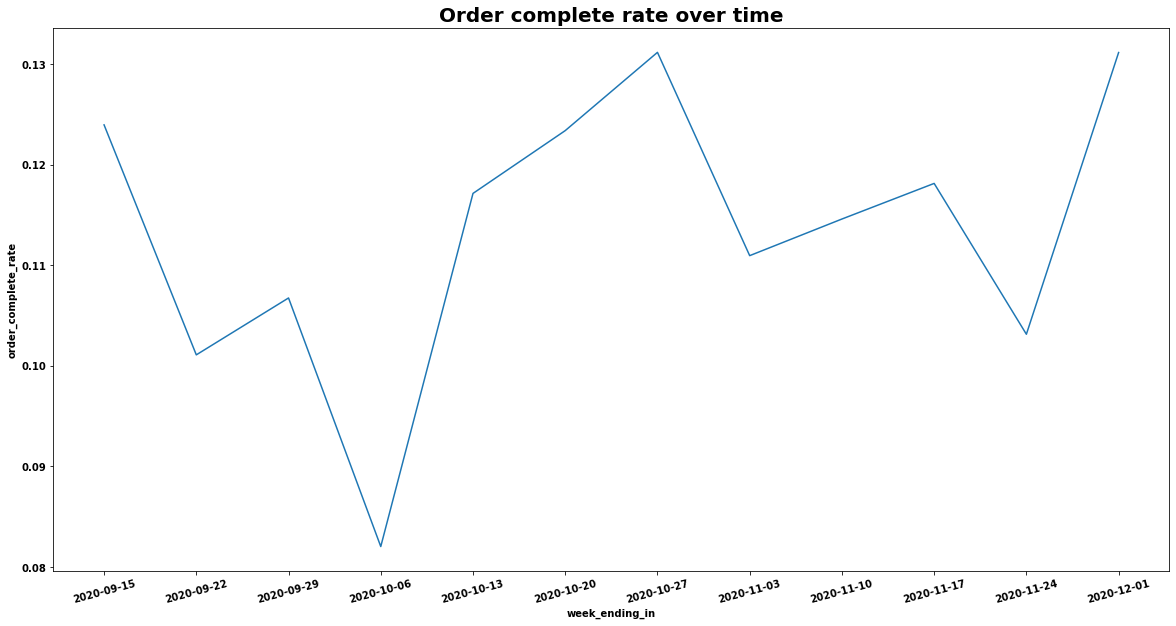

In [31]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=order_complete_rate['order_complete_rate'], x=order_complete_rate['week_ending_in'])
plt.xticks(order_complete_rate['week_ending_in'].values, rotation=15)
plt.title('Order complete rate over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric1.jpg", dpi=300)

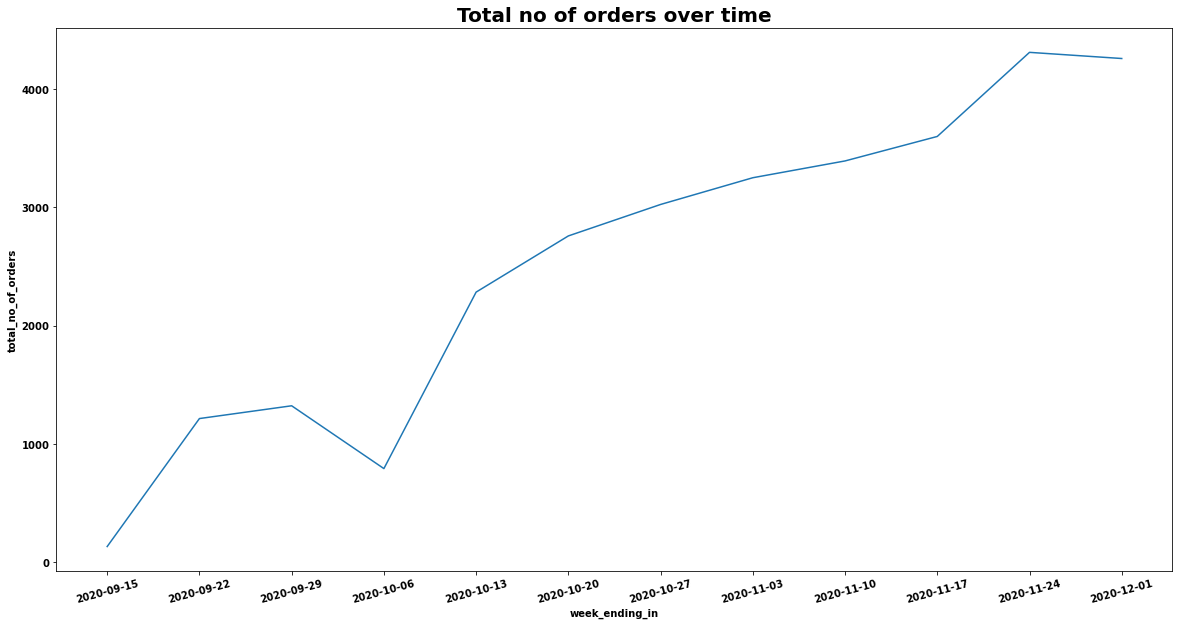

In [32]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=completed_orders['total_no_of_orders'], x=completed_orders['week_ending_in'])
plt.xticks(order_complete_rate['week_ending_in'].values, rotation=15)
plt.title('Total no of orders over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric2.jpg", dpi=300)

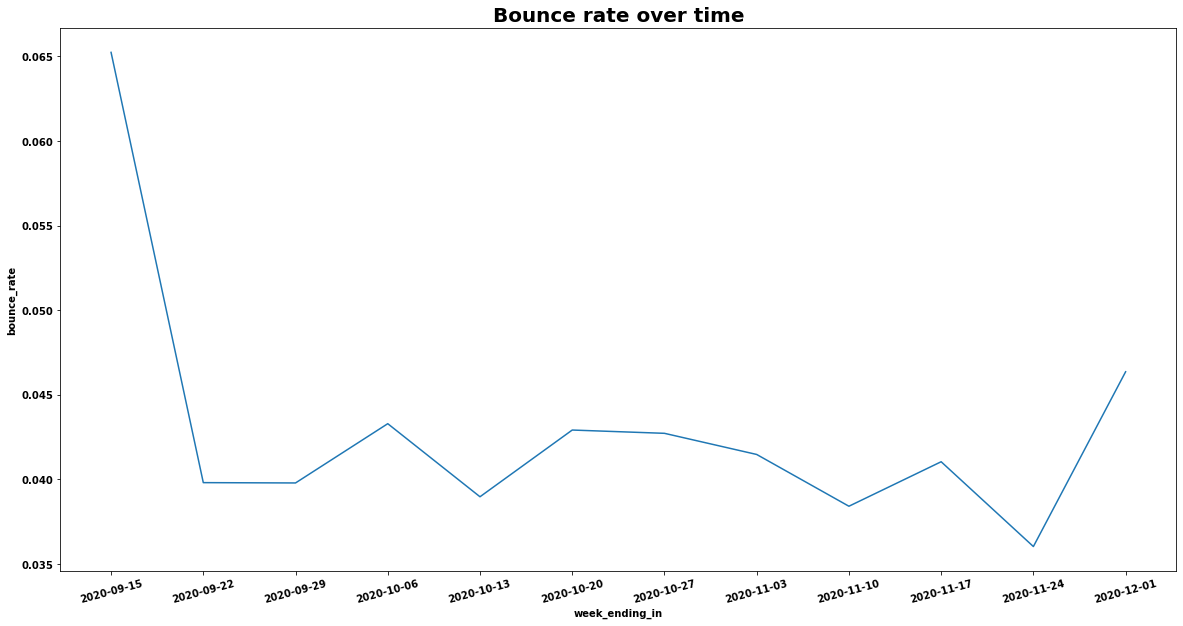

In [33]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=bounce_rate['bounce_rate'], x=bounce_rate['week_ending_in'])
plt.xticks(bounce_rate['week_ending_in'].values, rotation=15)
plt.title('Bounce rate over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric3.jpg", dpi=300)

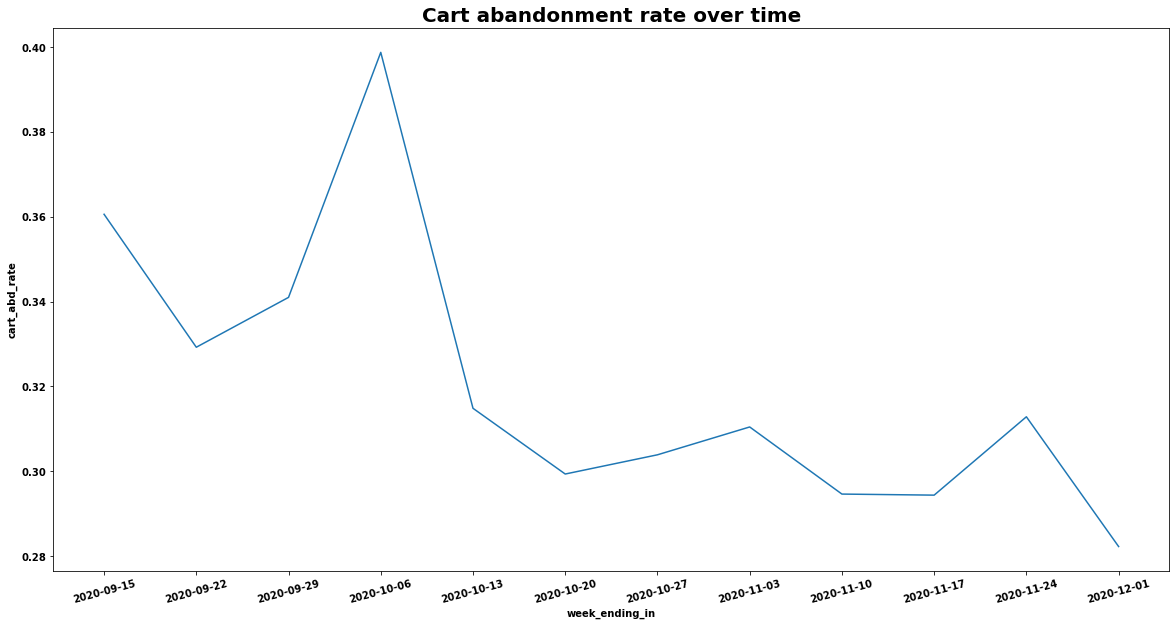

In [34]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=cart_abd_rate['cart_abd_rate'], x=cart_abd_rate['week_ending_in'])
plt.xticks(cart_abd_rate['week_ending_in'].values, rotation=15)
plt.title('Cart abandonment rate over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric4.jpg", dpi=300)

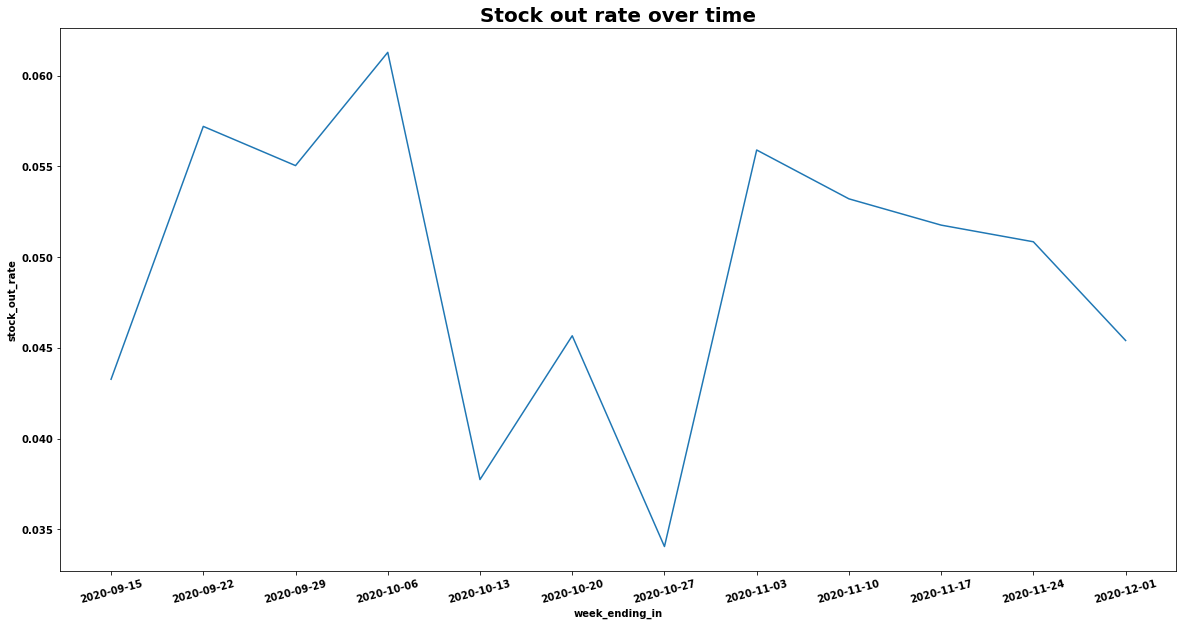

In [35]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(y=stock_out_rate['stock_out_rate'], x=stock_out_rate['week_ending_in'])
plt.xticks(stock_out_rate['week_ending_in'].values, rotation=15)
plt.title('Stock out rate over time', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/metric6.jpg", dpi=300)

In [36]:
users_with_orders = user_data[(user_data['avg_session_duration']<3000) & (user_data['times_purchased']>=1)]

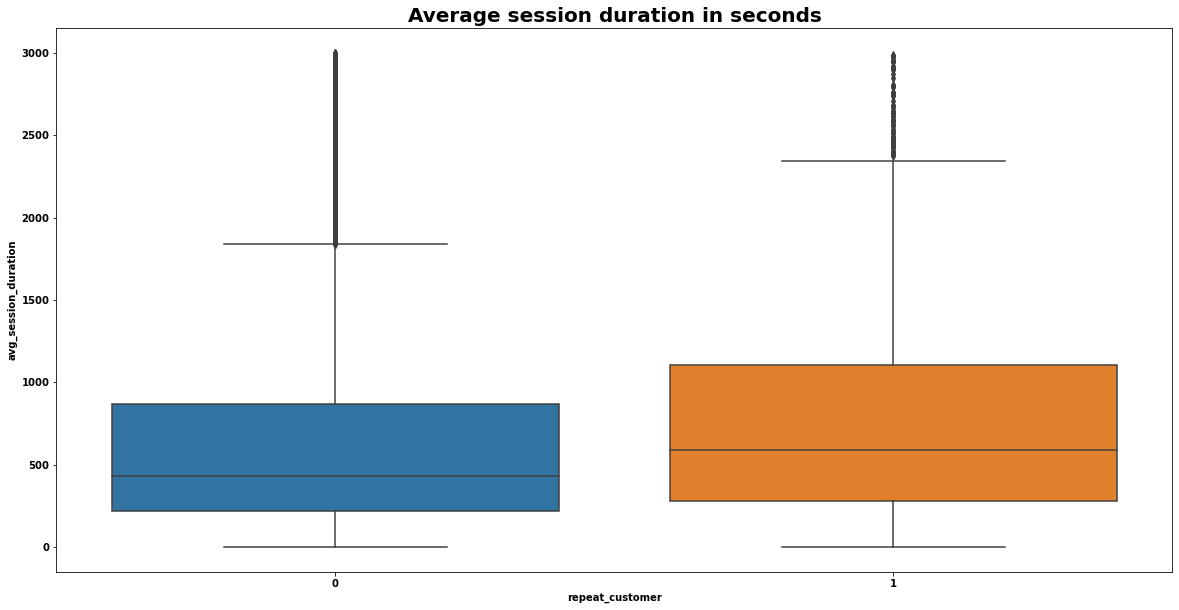

In [37]:
plt.figure(figsize=(20,10))
sns.boxplot(x="repeat_customer", y="avg_session_duration", data=users_with_orders)
plt.title('Average session duration in seconds', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/repeat_cust_avg_sess_dur.jpg", dpi=300)

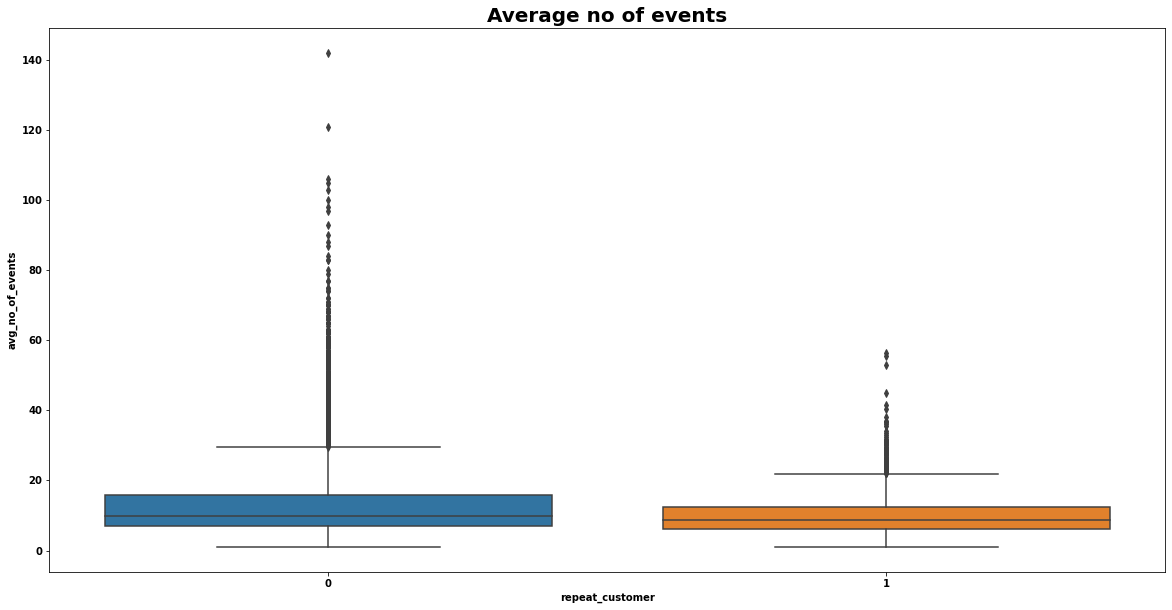

In [38]:
plt.figure(figsize=(20,10))
sns.boxplot(x="repeat_customer", y="avg_no_of_events", data=users_with_orders)
plt.title('Average no of events', size=20)
plt.savefig(f"{PROJECT_PATH}/reports/figures/repeat_cust_avg_no_events.jpg", dpi=300)

In [39]:
pd.crosstab(user_data['user_gender'], user_data['repeat_customer'], normalize='index')

repeat_customer,0,1
user_gender,,
Female,0.987584,0.012416
Male,0.987130,0.012870


In [40]:
pd.crosstab(user_data['most_used_device'], user_data['repeat_customer'], normalize='index')

repeat_customer,0,1
most_used_device,,
desktop,0.971720,0.028280
mobile,0.992855,0.007145
tablet,0.991889,0.008111


In [41]:
pd.crosstab(user_data['most_used_device_category'], user_data['repeat_customer'], normalize='index').loc[['Android', 'Windows', 'iPad', 'iPhone', 'macOS']]

repeat_customer,0,1
most_used_device_category,,
Android,0.979017,0.020983
Windows,0.964137,0.035863
iPad,0.991233,0.008767
iPhone,0.994540,0.005460
macOS,0.974363,0.025637


In [42]:
first_time_buyers = session_data[session_data['made_purchase'] == 1].sort_values(
    ['lb_user_id', 'session_end_time']).drop_duplicates('lb_user_id')

In [43]:
first_time_buyers = pd.merge(first_time_buyers, user_data[['lb_user_id', 'repeat_customer']], how='left', on='lb_user_id')

In [56]:
first_time_buyers['repeat_customer'].value_counts(normalize=True)

0    0.933288
1    0.066712
Name: repeat_customer, dtype: float64

# Modelling repeat customers from first time buyers

## One Hot Encoding

In [45]:
columns_for_ohe = ['device_category', 'user_gender', 'product_category']
for col in columns_for_ohe:
    ohe_df = pd.get_dummies(first_time_buyers[col], prefix=col, drop_first=True)
    first_time_buyers = pd.concat([first_time_buyers, ohe_df], axis=1)

In [63]:
first_time_buyers.drop(cols_to_drop, axis=1).columns

Index(['no_of_events', 'session_duration_sec', 'made_purchase', 'visit_count',
       'bought_on_first_visit', 'no_of_purchases', 'visited_prod_coll',
       'device_category_Chrome OS', 'device_category_Generic Linux',
       'device_category_Windows', 'device_category_iPad',
       'device_category_iPhone', 'device_category_iPod',
       'device_category_macOS', 'user_gender_Male', 'product_category_Apparel',
       'product_category_Home', 'product_category_Jewelry',
       'product_category_Others', 'product_category_none'],
      dtype='object')

In [46]:
cols_to_drop = ['session_id', 'lb_user_id', 'device', 'device_category', 'user_gender', 'product_category', 
                'user_state', 'session_end_time', 'session_start_time', 'event_sequence', 'repeat_customer']
X = first_time_buyers.drop(cols_to_drop, axis=1).values
y = first_time_buyers['repeat_customer'].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [57]:
Counter(y_train)

Counter({0: 17378, 1: 1241})

In [58]:
Counter(y_test)

Counter({0: 8559, 1: 613})

In [48]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1234, class_weight="balanced_subsample")

In [49]:
rf.fit(X_train, y_train, )

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=1234)

In [50]:
y_test_pred = rf.predict(X_test)

In [51]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=['non_repeat', 'repeat'], columns=['non_repeat', 'repeat'])

In [52]:
feat_imp = pd.DataFrame({'feature': first_time_buyers.drop(cols_to_drop, axis=1).columns, 'feat_imp': rf.feature_importances_})

In [64]:
feat_imp.sort_values('feat_imp', ascending=False).to_clipboard()

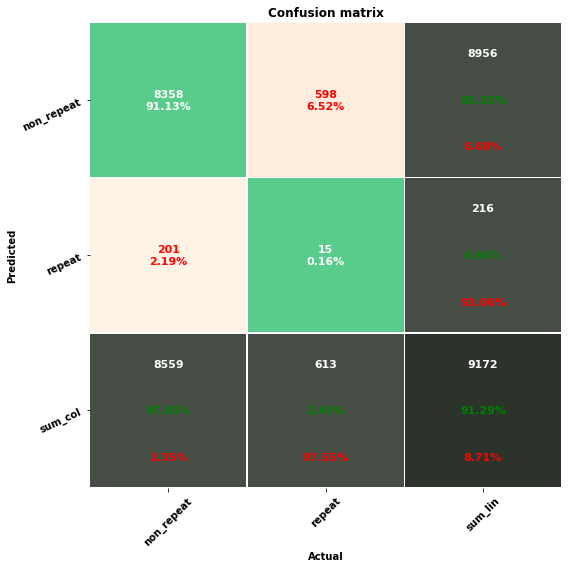

In [53]:
pretty_plot_confusion_matrix(df_cm, save_path=f"{PROJECT_PATH}/reports/figures/confusion_matrix_rf.jpg")